In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from os import path
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
df_train = train_data.copy()
df_test = test_data.copy()

In [4]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

# Understanding the Dataset

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

In [8]:
print(df_train.duplicated(['text', 'target']).sum())
print(df_train.duplicated(['text']).sum())

92
110


In [9]:
df_train = df_train.drop_duplicates(["text", "target"])
df_train = df_train.drop(index=df_train[df_train.duplicated('text', keep=False)].index)

In [10]:
len(df_train['keyword'].unique())

222

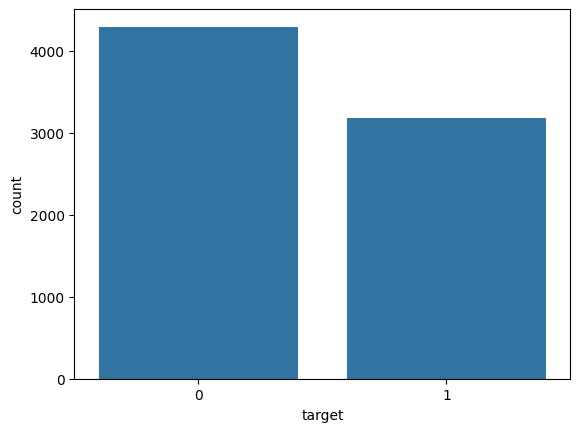

In [11]:
sns.countplot(x="target", data=df_train);

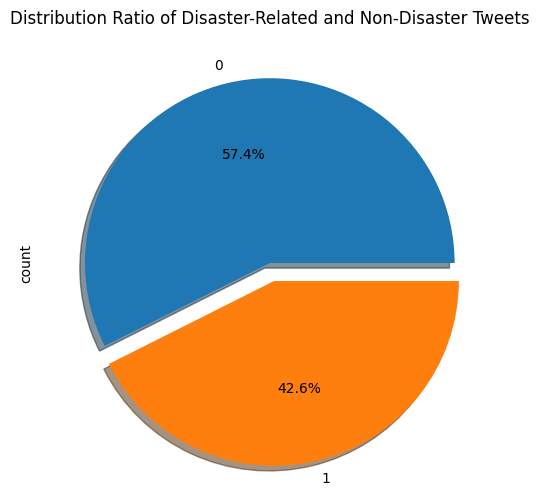

In [48]:
df_train["target"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True);
plt.title("Distribution Ratio of Disaster-Related and Non-Disaster Tweets");

# Keyword

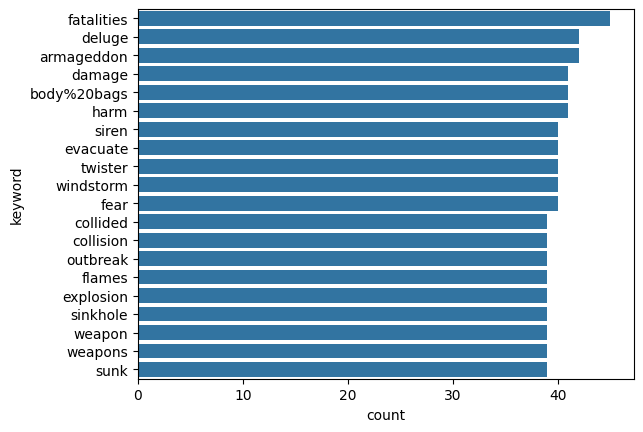

In [15]:
sns.barplot(y=df_train['keyword'].value_counts()[:20].index,x=df_train['keyword'].value_counts()[:20], orient='h');

In [16]:
df_train['keyword'].value_counts()[:20]

keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
siren          40
evacuate       40
twister        40
windstorm      40
fear           40
collided       39
collision      39
outbreak       39
flames         39
explosion      39
sinkhole       39
weapon         39
weapons        39
sunk           39
Name: count, dtype: int64

In [17]:
encoder = LabelEncoder()
df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

In [18]:
df_train.head()

id  keyword location                                               text  \
0   1      221      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4      221      NaN             Forest fire near La Ronge Sask. Canada   
2   5      221      NaN  All residents asked to 'shelter in place' are ...   
3   6      221      NaN  13,000 people receive #wildfires evacuation or...   
4   7      221      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

# Locations

In [19]:
df_train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

<Axes: xlabel='count', ylabel='location'>

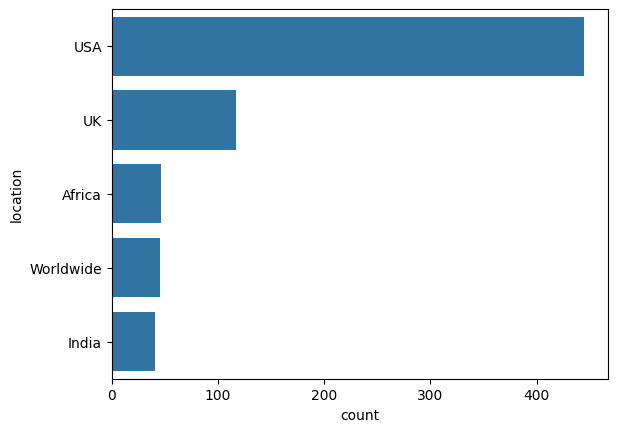

In [20]:
sns.barplot(y=df_train['location'].value_counts()[:5].index,x=df_train['location'].value_counts()[:5], orient='h')

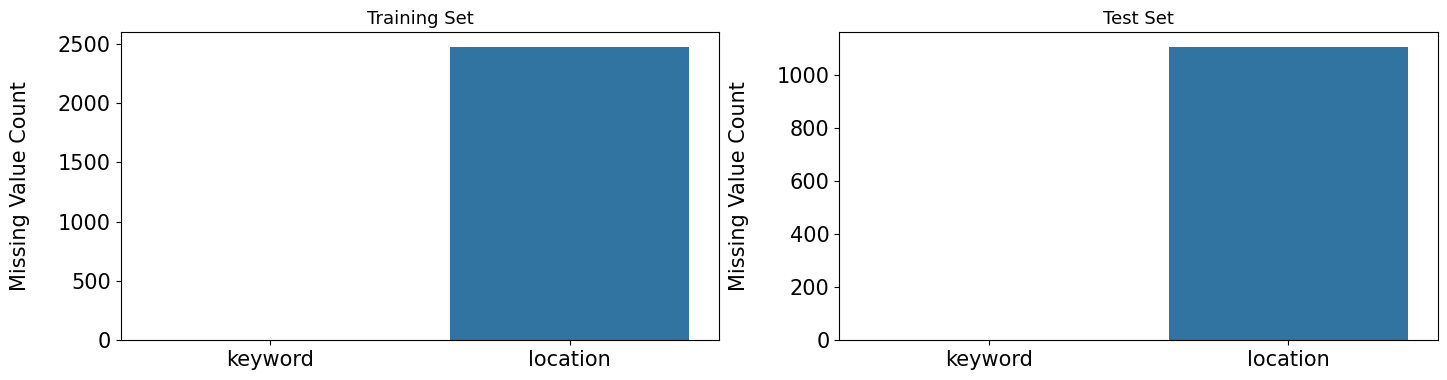

In [21]:
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [22]:
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

In [23]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [24]:
df

id  keyword  location  \
0          1      221  no_{col}   
1          4      221  no_{col}   
2          5      221  no_{col}   
3          6      221  no_{col}   
4          7      221  no_{col}   
...      ...      ...       ...   
10743  10861      221  no_{col}   
10744  10865      221  no_{col}   
10745  10868      221  no_{col}   
10746  10874      221  no_{col}   
10747  10875      221  no_{col}   

                                                    text  target  
0      Our Deeds are the Reason of this #earthquake M...     1.0  
1                 Forest fire near La Ronge Sask. Canada     1.0  
2      All residents asked to 'shelter in place' are ...     1.0  
3      13,000 people receive #wildfires evacuation or...     1.0  
4      Just got sent this photo from Ruby #Alaska as ...     1.0  
...                                                  ...     ...  
10743  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...     NaN  
10744  Storm in RI worse than last hurricane. My city...     NaN  
10745  Green Line derailment in Chicago http://t.co/U...     NaN  
10746  MEG issues Hazardous Weather Outlook (HWO) htt...     NaN  
10747  #CityofCalgary has activated its Municipal Eme...     NaN  

[10748 rows x 5 columns]

In [25]:
df = df.drop(['id'], axis=1)
#df_test = df_test.drop(['id', 'location'], axis=1)

# Mathematical Operations and Simple Feature Extraction

## a. Number of Letters/Characters

In [26]:
x_df = df.copy()

In [27]:
x_df["text"].str.len()

0         69
1         38
2        133
3         65
4         88
        ... 
10743     55
10744    139
10745     55
10746     65
10747     68
Name: text, Length: 10748, dtype: int64

In [36]:
x_df["Number of Letters"] = x_df["text"].str.len()
x_df.head()

keyword  location                                               text  \
0      221  no_{col}  Our Deeds are the Reason of this #earthquake M...   
1      221  no_{col}             Forest fire near La Ronge Sask. Canada   
2      221  no_{col}  All residents asked to 'shelter in place' are ...   
3      221  no_{col}  13,000 people receive #wildfires evacuation or...   
4      221  no_{col}  Just got sent this photo from Ruby #Alaska as ...   

   target  harf_sayisi  kelime_sayisi  Number of Letters/Characters  \
0     1.0           69             13                            69   
1     1.0           38              7                            38   
2     1.0          133             22                           133   
3     1.0           65              9                            65   
4     1.0           88             17                            88   

   Number of Words  Number of Letters  
0               13                 69  
1                7                 38  
2               22                133  
3                9                 65  
4               17                 88

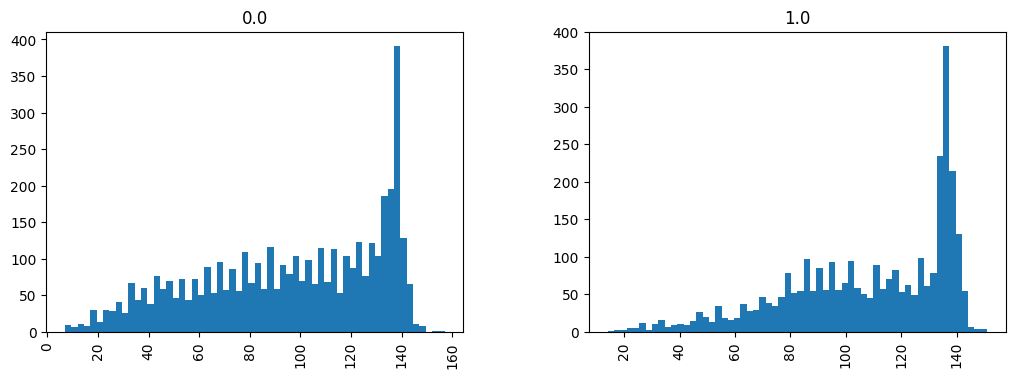

In [37]:
x_df.hist(column='Number of Letters',by='target',bins=60,figsize=(12,4));

## b. Number of Words

In [38]:
x_df["Number of Words"] = x_df["text"].apply(lambda x:len(str(x).split(" ")))
x_df.head()

keyword  location                                               text  \
0      221  no_{col}  Our Deeds are the Reason of this #earthquake M...   
1      221  no_{col}             Forest fire near La Ronge Sask. Canada   
2      221  no_{col}  All residents asked to 'shelter in place' are ...   
3      221  no_{col}  13,000 people receive #wildfires evacuation or...   
4      221  no_{col}  Just got sent this photo from Ruby #Alaska as ...   

   target  harf_sayisi  kelime_sayisi  Number of Letters/Characters  \
0     1.0           69             13                            69   
1     1.0           38              7                            38   
2     1.0          133             22                           133   
3     1.0           65              9                            65   
4     1.0           88             17                            88   

   Number of Words  Number of Letters  
0               13                 69  
1                7                 38  
2               22                133  
3                9                 65  
4               17                 88

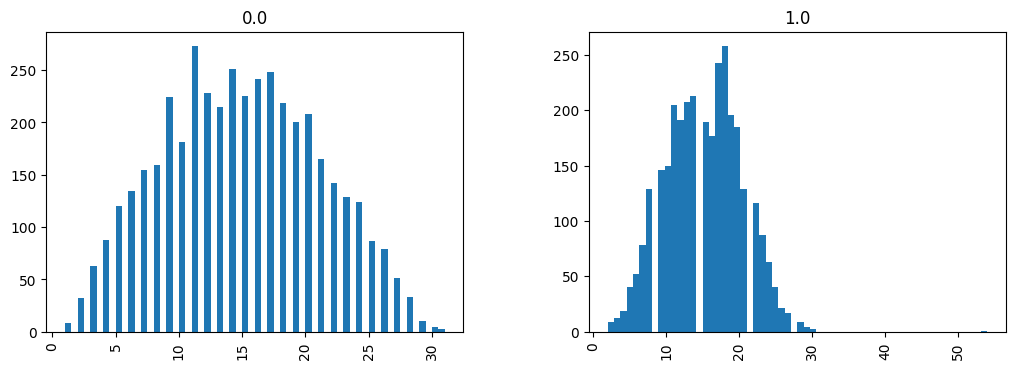

In [39]:
x_df.hist(column='Number of Words',by='target',bins=60,figsize=(12,4));

## c. Detecting & Counting Numbers

In [41]:
x_df["number_count"] = train_data["text"].apply(lambda x: len([x for x in x.split()
                                      if x.isdigit()]))

In [42]:
x_df.head()

keyword  location                                               text  \
0      221  no_{col}  Our Deeds are the Reason of this #earthquake M...   
1      221  no_{col}             Forest fire near La Ronge Sask. Canada   
2      221  no_{col}  All residents asked to 'shelter in place' are ...   
3      221  no_{col}  13,000 people receive #wildfires evacuation or...   
4      221  no_{col}  Just got sent this photo from Ruby #Alaska as ...   

   target  harf_sayisi  kelime_sayisi  Number of Letters/Characters  \
0     1.0           69             13                            69   
1     1.0           38              7                            38   
2     1.0          133             22                           133   
3     1.0           65              9                            65   
4     1.0           88             17                            88   

   Number of Words  Number of Letters  number_count  
0               13                 69           0.0  
1                7                 38           0.0  
2               22                133           0.0  
3                9                 65           0.0  
4               17                 88           0.0

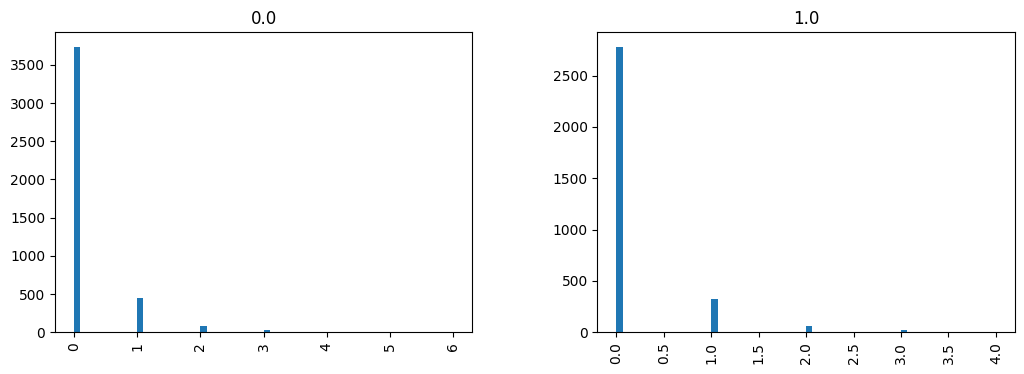

In [43]:
x_df.hist(column='number_count',by='target',bins=60,figsize=(12,4));

In [44]:
x_df.describe().T

count        mean        std  min   25%  \
keyword                       10748.0  110.442966  64.495341  0.0  55.0   
target                         7485.0    0.425919   0.494515  0.0   0.0   
harf_sayisi                   10748.0  101.253163  33.874008  5.0  78.0   
kelime_sayisi                 10748.0   14.923148   5.793816  1.0  11.0   
Number of Letters/Characters  10748.0  101.253163  33.874008  5.0  78.0   
Number of Words               10748.0   14.923148   5.793816  1.0  11.0   
Number of Letters             10748.0  101.253163  33.874008  5.0  78.0   
number_count                   7613.0    0.161960   0.468294  0.0   0.0   

                                50%    75%    max  
keyword                       110.0  167.0  221.0  
target                          0.0    1.0    1.0  
harf_sayisi                   107.0  133.0  157.0  
kelime_sayisi                  15.0   19.0   54.0  
Number of Letters/Characters  107.0  133.0  157.0  
Number of Words                15.0   19.0   54.0  
Number of Letters             107.0  133.0  157.0  
number_count                    0.0    0.0    6.0

<Figure size 1200x800 with 0 Axes>

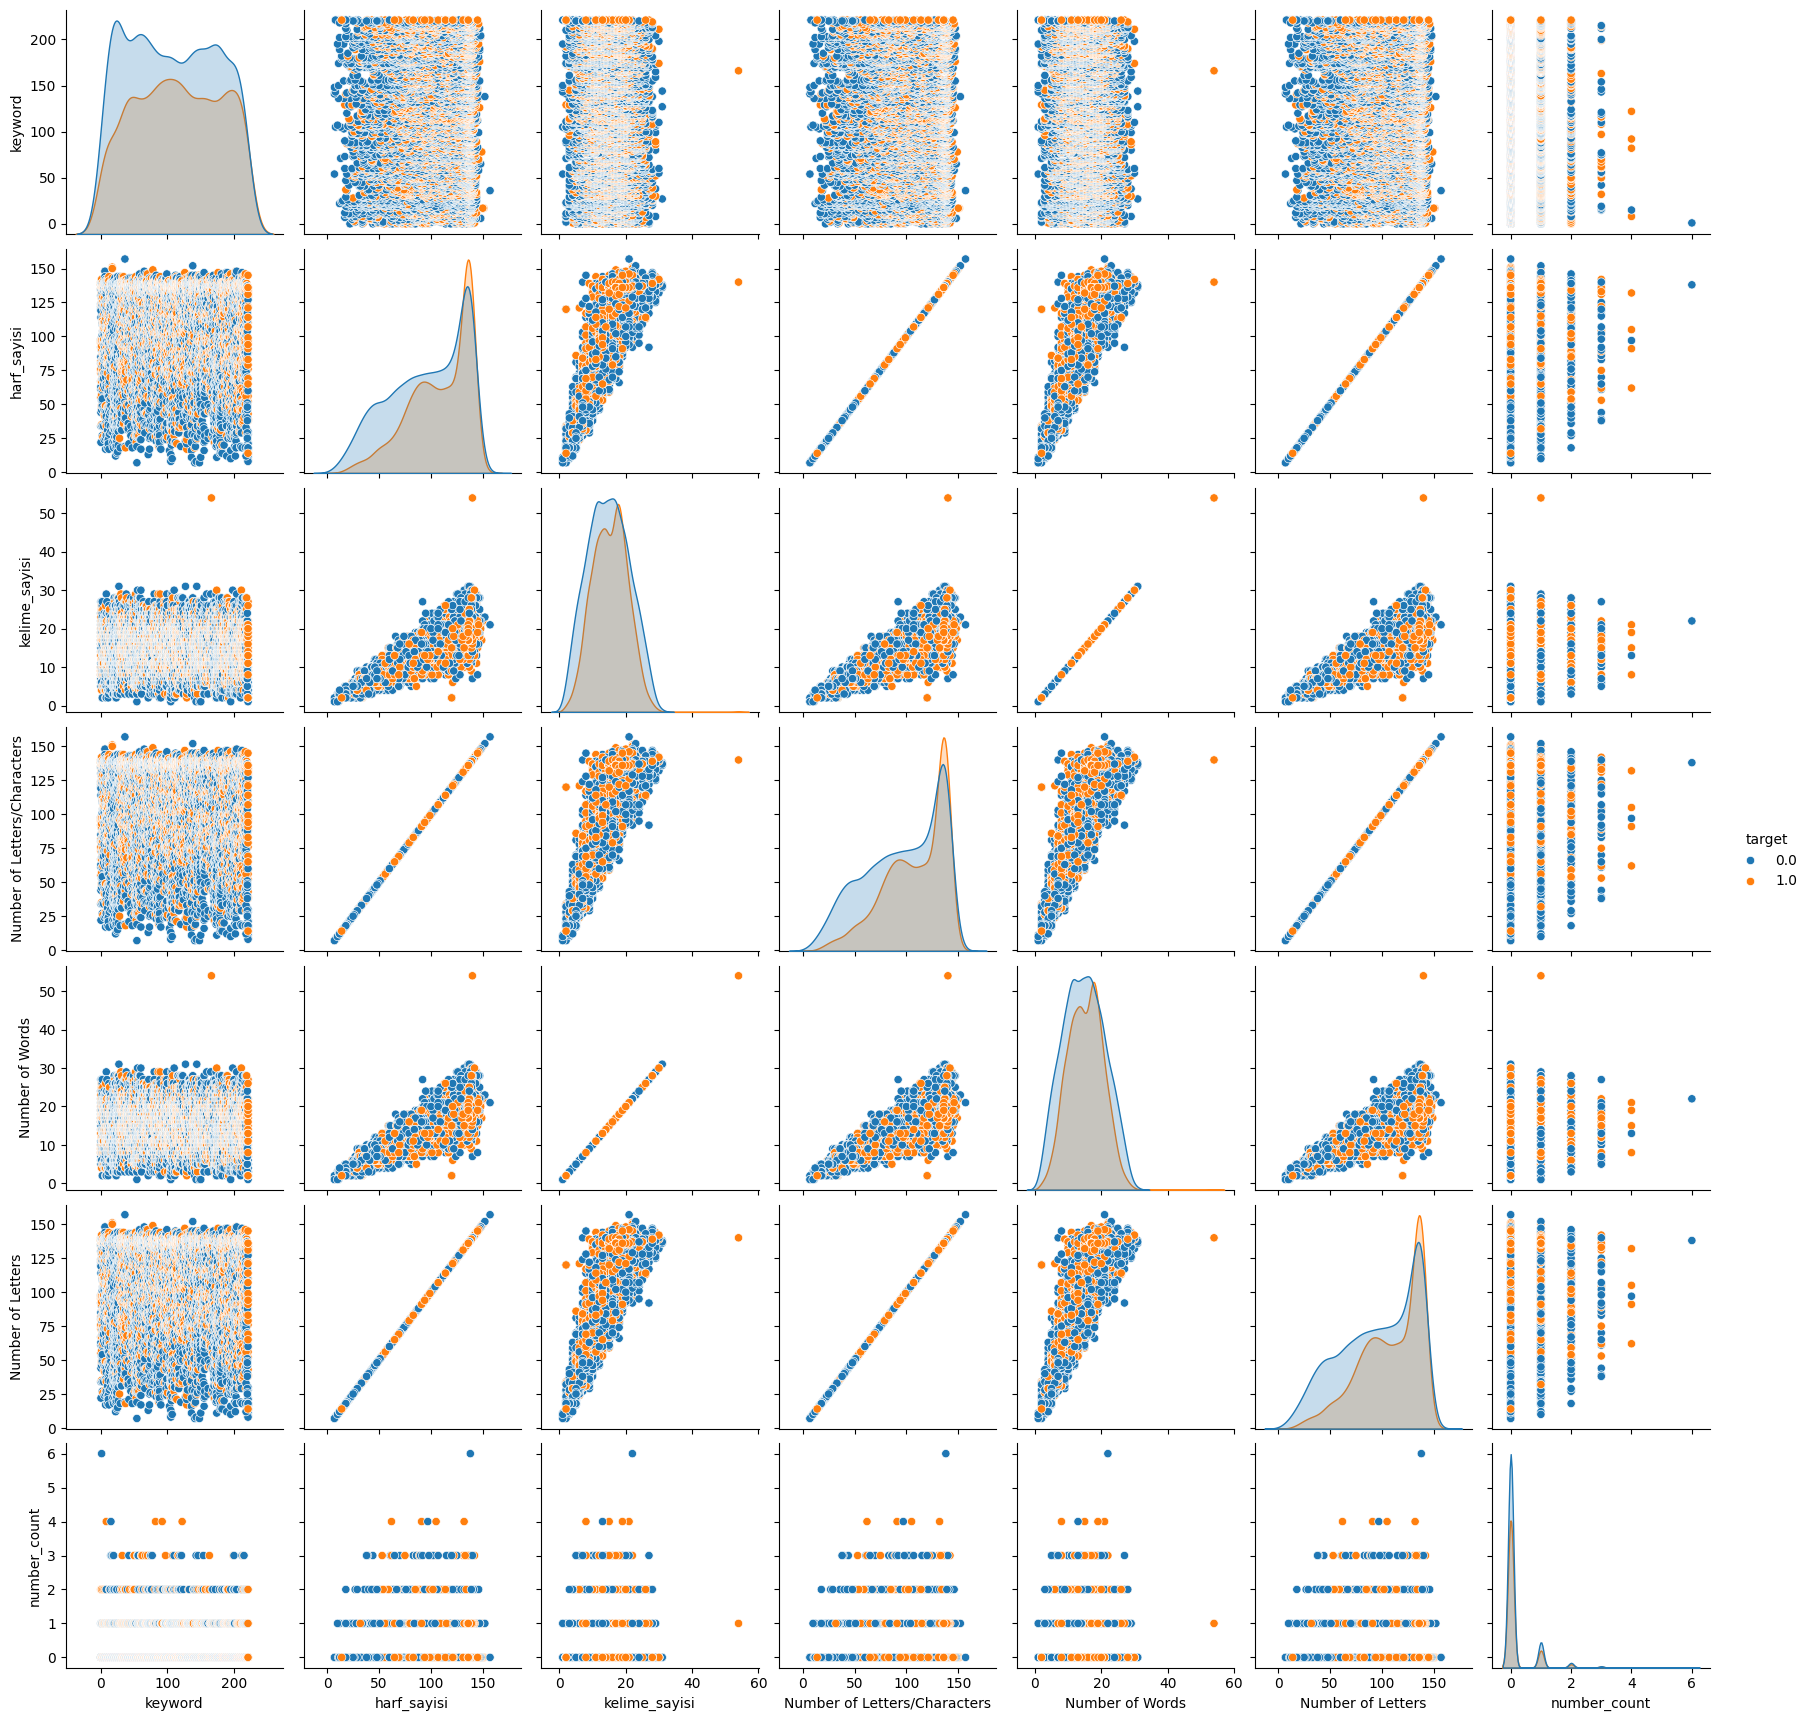

In [45]:
plt.figure(figsize=(12,8));
fg = sns.pairplot(data=x_df, hue="target")
plt.show(fg)

## Text Preprocessing

In [46]:
df = df.reset_index(drop=True)
df.head(50)

keyword                       location  \
0       221                       no_{col}   
1       221                       no_{col}   
2       221                       no_{col}   
3       221                       no_{col}   
4       221                       no_{col}   
5       221                       no_{col}   
6       221                       no_{col}   
7       221                       no_{col}   
8       221                       no_{col}   
9       221                       no_{col}   
10      221                       no_{col}   
11      221                       no_{col}   
12      221                       no_{col}   
13      221                       no_{col}   
14      221                       no_{col}   
15      221                       no_{col}   
16      221                       no_{col}   
17      221                       no_{col}   
18      221                       no_{col}   
19      221                       no_{col}   
20      221                       no_{col}   
21      221                       no_{col}   
22      221                       no_{col}   
23      221                       no_{col}   
24      221                       no_{col}   
25      221                       no_{col}   
26      221                       no_{col}   
27      221                       no_{col}   
28      221                       no_{col}   
29      221                       no_{col}   
30      221                       no_{col}   
31        0                     Birmingham   
32        0  Est. September 2012 - Bristol   
33        0                         AFRICA   
34        0               Philadelphia, PA   
35        0                             UK   
36        0                       Pretoria   
37        0                   World Wide!!   
38        0                       no_{col}   
39        0                 Paranaque City   
40        0                 Live On Webcam   
41        0                       no_{col}   
42        0                      milky way   
43        0                       no_{col}   
44        0                       no_{col}   
45        0                       no_{col}   
46        0      GREENSBORO,NORTH CAROLINA   
47        0                       no_{col}   
48        0                       England.   
49        0       Sheffield Township, Ohio   

                                                 text  target  
0   Our Deeds are the Reason of this #earthquake M...     1.0  
1              Forest fire near La Ronge Sask. Canada     1.0  
2   All residents asked to 'shelter in place' are ...     1.0  
3   13,000 people receive #wildfires evacuation or...     1.0  
4   Just got sent this photo from Ruby #Alaska as ...     1.0  
5   #RockyFire Update => California Hwy. 20 closed...     1.0  
6   #flood #disaster Heavy rain causes flash flood...     1.0  
7   I'm on top of the hill and I can see a fire in...     1.0  
8   There's an emergency evacuation happening now ...     1.0  
9   I'm afraid that the tornado is coming to our a...     1.0  
10        Three people died from the heat wave so far     1.0  
11  Haha South Tampa is getting flooded hah- WAIT ...     1.0  
12  #raining #flooding #Florida #TampaBay #Tampa 1...     1.0  
13            #Flood in Bago Myanmar #We arrived Bago     1.0  
14  Damage to school bus on 80 in multi car crash ...     1.0  
15                                     What's up man?     0.0  
16                                      I love fruits     0.0  
17                                   Summer is lovely     0.0  
18                                  My car is so fast     0.0  
19                       What a goooooooaaaaaal!!!!!!     0.0  
20                             this is ridiculous....     0.0  
21                                  London is cool ;)     0.0  
22                                        Love skiing     0.0  
23                              What a wonderful day!     0.0  
24                                           LOOOOOOL    

### URL Separation

In [49]:
for i in range(len(df)):
    df["text"][i] = re.sub('(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#$\%\^\&\*_\-\=\+\\/\?\.\:\;\'\,]*)?', '', df["text"][i])

df.head()

keyword  location                                               text  \
0      221  no_{col}  Our Deeds are the Reason of this #earthquake M...   
1      221  no_{col}             Forest fire near La Ronge Sask. Canada   
2      221  no_{col}  All residents asked to 'shelter in place' are ...   
3      221  no_{col}  13,000 people receive #wildfires evacuation or...   
4      221  no_{col}  Just got sent this photo from Ruby #Alaska as ...   

   target  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0

### RT Separation

In [50]:
for i in range(len(df)):
    df["text"][i] = re.sub('RT', '', df["text"][i])

df.head()

keyword  location                                               text  \
0      221  no_{col}  Our Deeds are the Reason of this #earthquake M...   
1      221  no_{col}             Forest fire near La Ronge Sask. Canada   
2      221  no_{col}  All residents asked to 'shelter in place' are ...   
3      221  no_{col}  13,000 people receive #wildfires evacuation or...   
4      221  no_{col}  Just got sent this photo from Ruby #Alaska as ...   

   target  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0

### Separation of Special Characters

In [51]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])

df.head(50)

keyword                       location  \
0       221                       no_{col}   
1       221                       no_{col}   
2       221                       no_{col}   
3       221                       no_{col}   
4       221                       no_{col}   
5       221                       no_{col}   
6       221                       no_{col}   
7       221                       no_{col}   
8       221                       no_{col}   
9       221                       no_{col}   
10      221                       no_{col}   
11      221                       no_{col}   
12      221                       no_{col}   
13      221                       no_{col}   
14      221                       no_{col}   
15      221                       no_{col}   
16      221                       no_{col}   
17      221                       no_{col}   
18      221                       no_{col}   
19      221                       no_{col}   
20      221                       no_{col}   
21      221                       no_{col}   
22      221                       no_{col}   
23      221                       no_{col}   
24      221                       no_{col}   
25      221                       no_{col}   
26      221                       no_{col}   
27      221                       no_{col}   
28      221                       no_{col}   
29      221                       no_{col}   
30      221                       no_{col}   
31        0                     Birmingham   
32        0  Est. September 2012 - Bristol   
33        0                         AFRICA   
34        0               Philadelphia, PA   
35        0                             UK   
36        0                       Pretoria   
37        0                   World Wide!!   
38        0                       no_{col}   
39        0                 Paranaque City   
40        0                 Live On Webcam   
41        0                       no_{col}   
42        0                      milky way   
43        0                       no_{col}   
44        0                       no_{col}   
45        0                       no_{col}   
46        0      GREENSBORO,NORTH CAROLINA   
47        0                       no_{col}   
48        0                       England.   
49        0       Sheffield Township, Ohio   

                                                 text  target  
0   Our Deeds are the Reason of this  earthquake M...     1.0  
1              Forest fire near La Ronge Sask  Canada     1.0  
2   All residents asked to  shelter in place  are ...     1.0  
3          people receive  wildfires evacuation or...     1.0  
4   Just got sent this photo from Ruby  Alaska as ...     1.0  
5    RockyFire Update    California Hwy     closed...     1.0  
6    flood  disaster Heavy rain causes flash flood...     1.0  
7   I m on top of the hill and I can see a fire in...     1.0  
8   There s an emergency evacuation happening now ...     1.0  
9   I m afraid that the tornado is coming to our a...     1.0  
10        Three people died from the heat wave so far     1.0  
11  Haha South Tampa is getting flooded hah  WAIT ...     1.0  
12   raining  flooding  Florida  TampaBay  Tampa  ...     1.0  
13             Flood in Bago Myanmar  We arrived Bago     1.0  
14  Damage to school bus on    in multi car crash ...     1.0  
15                                     What s up man      0.0  
16                                      I love fruits     0.0  
17                                   Summer is lovely     0.0  
18                                  My car is so fast     0.0  
19                       What a goooooooaaaaaal           0.0  
20                             this is ridiculous         0.0  
21                                  London is cool        0.0  
22                                        Love skiing     0.0  
23                              What a wonderful day      0.0  
24                                           LOOOOOOL    

### Uppercase - Lowercase Conversion

In [52]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

keyword  location                                               text  \
0      221  no_{col}  our deeds are the reason of this earthquake ma...   
1      221  no_{col}              forest fire near la ronge sask canada   
2      221  no_{col}  all residents asked to shelter in place are be...   
3      221  no_{col}  people receive wildfires evacuation orders in ...   
4      221  no_{col}  just got sent this photo from ruby alaska as s...   

   target  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0

### Stop Words

In [54]:
import nltk

In [59]:

from nltk.corpus import stopwords
sw = stopwords.words('english')
sw

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [60]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [61]:
df.head(7000)

keyword                    location  \
0         221                    no_{col}   
1         221                    no_{col}   
2         221                    no_{col}   
3         221                    no_{col}   
4         221                    no_{col}   
...       ...                         ...   
6995      207                          UK   
6996      207                    no_{col}   
6997      207              Oshawa/Toronto   
6998      207  Very SW CA, USA....Draenor   
6999      207                    no_{col}   

                                                   text  target  
0          deeds reason earthquake may allah forgive us     1.0  
1                 forest fire near la ronge sask canada     1.0  
2     residents asked shelter place notified officer...     1.0  
3     people receive wildfires evacuation orders cal...     1.0  
4     got sent photo ruby alaska smoke wildfires pou...     1.0  
...                                                 ...     ...  
6995  pov video captures violent landing amsterdam a...     1.0  
6996  storm blitzes traverse city disrupts managemen...     1.0  
6997  one violent belligerent storm enjoying watchin...     1.0  
6998    iateyourfood yikes poor pup weird violent storm     1.0  
6999  brief violent storm swept chicago area sunday ...     1.0  

[7000 rows x 4 columns]

### Deletion of Infrequent Expressions

In [62]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

words   tf
0   amp  508
1  like  488
2  fire  362
3   get  337
4   new  330

In [63]:
sil = least[least["tf"] < 50]
sil

words  tf
369        wrecked  49
370    obliterated  49
371         report  49
372     obliterate  49
373     detonation  49
...            ...  ..
20111         jsyk   1
20112    thrillhho   1
20113         tyme   1
20114    smackdown   1
20115    yakuboobs   1

[19747 rows x 2 columns]

In [66]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [68]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [64]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

### Lemmitization

In [69]:
df[:20]

keyword  location                                               text  \
0       221  no_{col}         deed reason earthquake may allah forgive u   
1       221  no_{col}              forest fire near la ronge sask canada   
2       221  no_{col}  resident asked shelter place notified officer ...   
3       221  no_{col}  people receive wildfire evacuation order calif...   
4       221  no_{col}  got sent photo ruby alaska smoke wildfire pour...   
5       221  no_{col}  rockyfire update california hwy closed directi...   
6       221  no_{col}  flood disaster heavy rain cause flash flooding...   
7       221  no_{col}                             top hill see fire wood   
8       221  no_{col}  emergency evacuation happening building across...   
9       221  no_{col}                         afraid tornado coming area   
10      221  no_{col}                    three people died heat wave far   
11      221  no_{col}  haha south tampa getting flooded hah wait seco...   
12      221  no_{col}  raining flooding florida tampabay tampa day lo...   
13      221  no_{col}                    flood bago myanmar arrived bago   
14      221  no_{col}         damage school bus multi car crash breaking   
15      221  no_{col}                                                man   
16      221  no_{col}                                         love fruit   
17      221  no_{col}                                      summer lovely   
18      221  no_{col}                                           car fast   
19      221  no_{col}                                    goooooooaaaaaal   

    target  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      1.0  
5      1.0  
6      1.0  
7      1.0  
8      1.0  
9      1.0  
10     1.0  
11     1.0  
12     1.0  
13     1.0  
14     1.0  
15     0.0  
16     0.0  
17     0.0  
18     0.0  
19     0.0

## Term Frequency (TF)

In [70]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [71]:
tf1.head()

words   tf
0  fire  517
1   amp  508
2  like  491
3   get  382
4     u  379

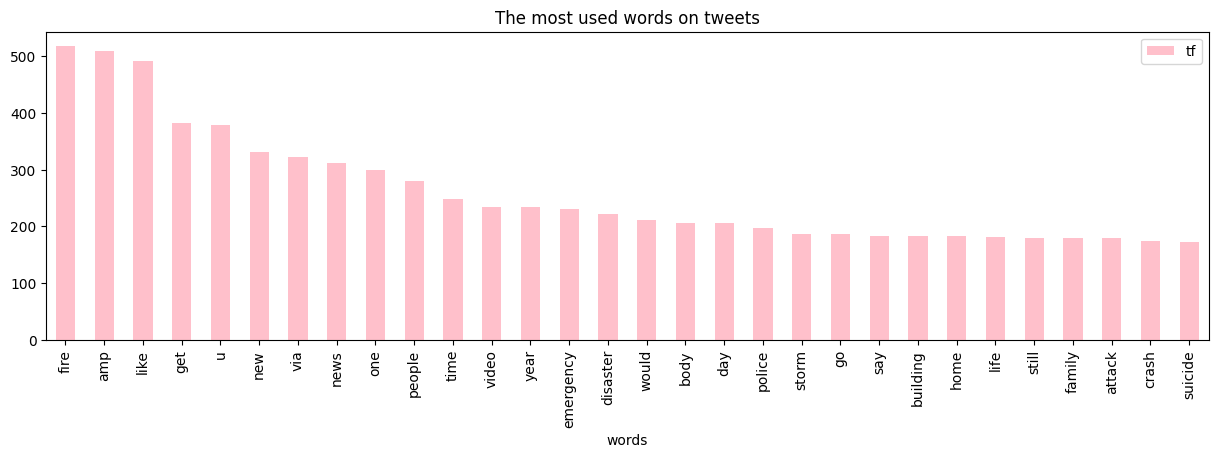

In [74]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('The most used words on tweets');

In [75]:
non_disaster_tweets_count = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(20)
non_disaster_tweets_count_df = pd.DataFrame(non_disaster_tweets_count, columns=["words", "freq"])
print("The 20 most frequently used words in tweets that are not related to disasters:")
non_disaster_tweets_count_df

The 20 most frequently used words in tweets that are not related to disasters:


words  freq
0     like   254
1      amp   208
2      get   185
3      new   171
4        u   160
5      one   139
6     body   119
7     time   106
8      day   104
9    video   101
10   would    99
11     via    98
12    love    96
13      go    92
14  people    92
15    know    91
16    fire    88
17    back    86
18     got    85
19     see    84

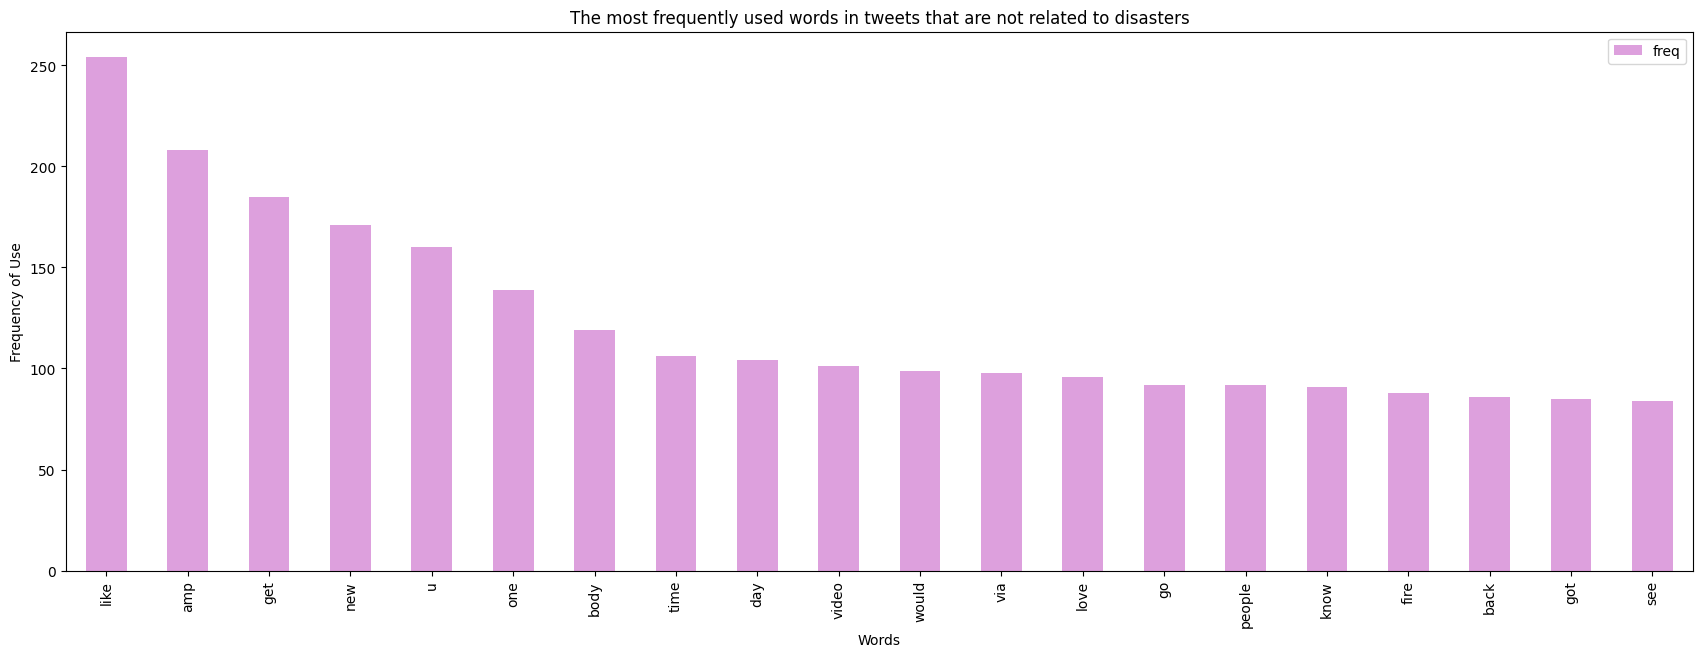

In [76]:
non_disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum");
plt.title('The most frequently used words in tweets that are not related to disasters');
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

In [77]:
disaster_tweets_count = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(20)
disaster_tweets_count_df = pd.DataFrame(disaster_tweets_count, columns=["words", "freq"])
print("The 20 most frequently used words in tweets related to disasters:")
disaster_tweets_count_df

The 20 most frequently used words in tweets related to disasters:


words  freq
0         fire   262
1         news   149
2          amp   134
3          via   119
4     disaster   117
5   california   114
6            u   111
7       police   107
8      suicide   106
9       people   102
10        home   102
11      family   102
12      killed    95
13       storm    95
14        year    93
15   hiroshima    93
16       train    92
17        like    91
18       crash    90
19        bomb    87

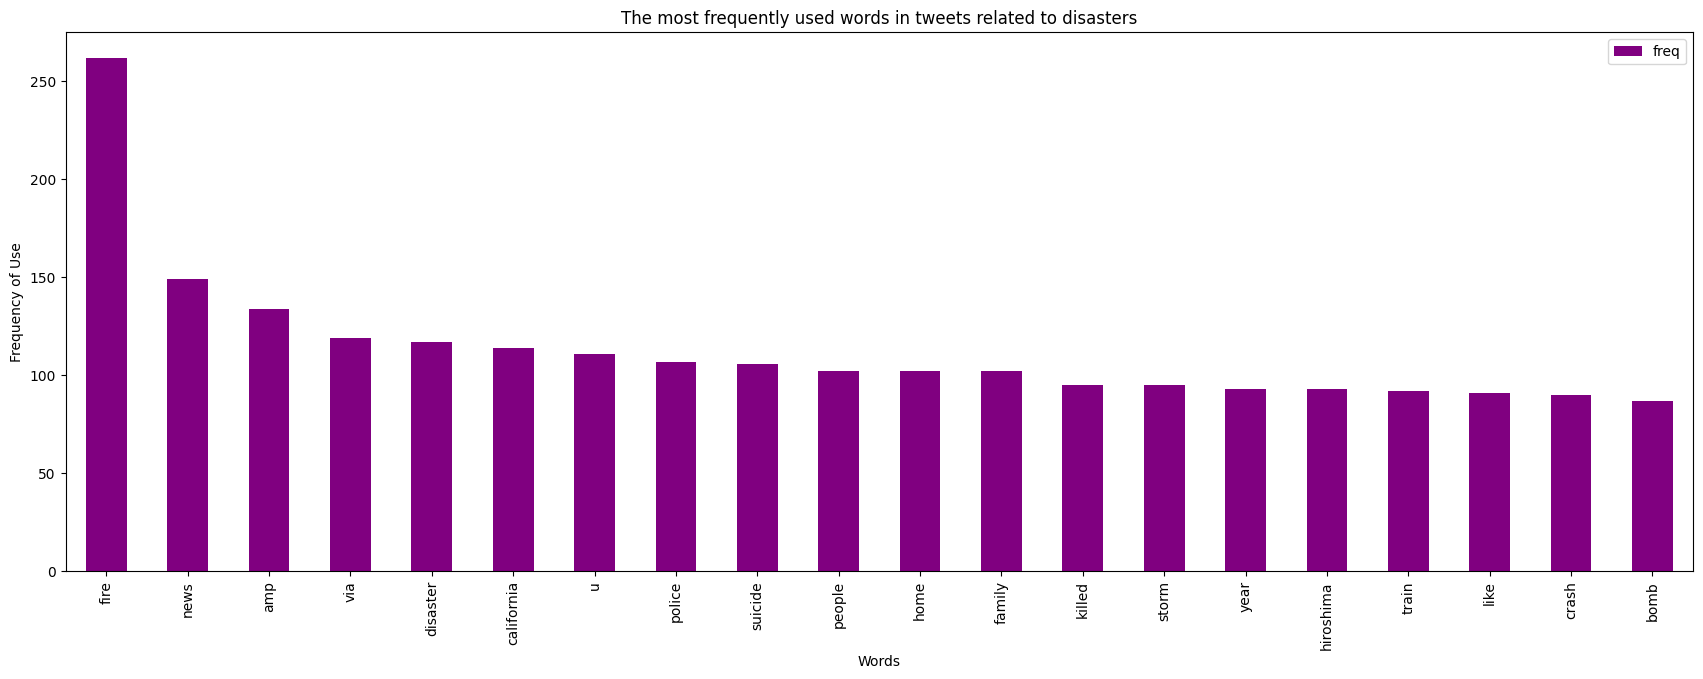

In [78]:
disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple");
plt.title('The most frequently used words in tweets related to disasters');
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

## Word Cloud

In [79]:
disaster_text = " ".join(i for i in (df[df['target']==1]['text']))

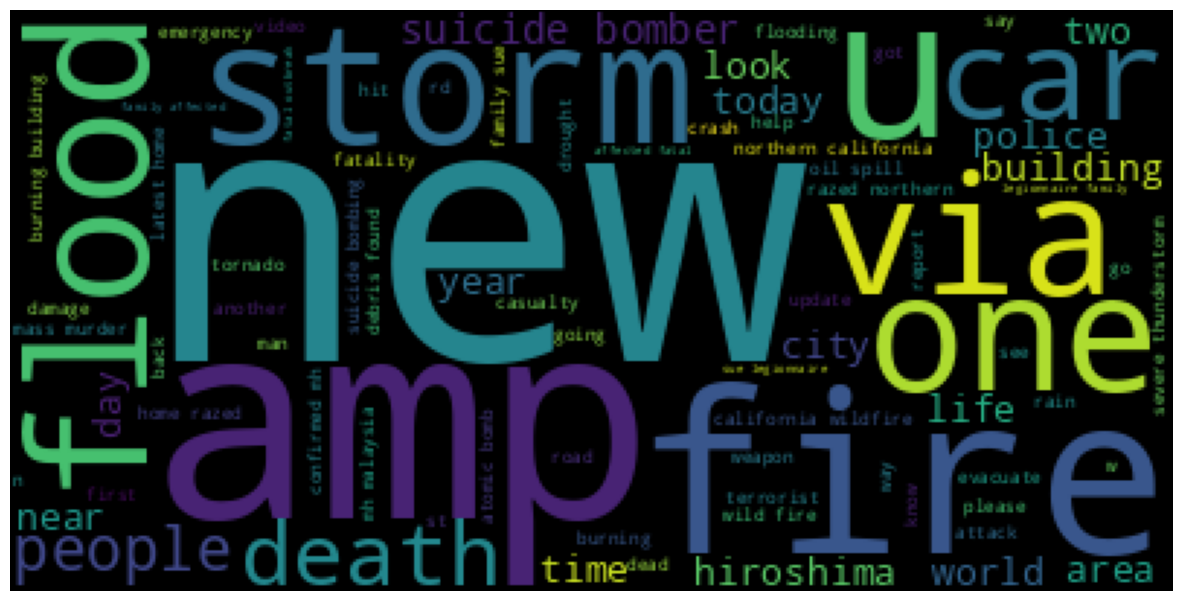

In [80]:
wordcloud = WordCloud(background_color= "black").generate(disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [81]:
non_disaster_text = " ".join(i for i in (df[df['target']==0]['text']))

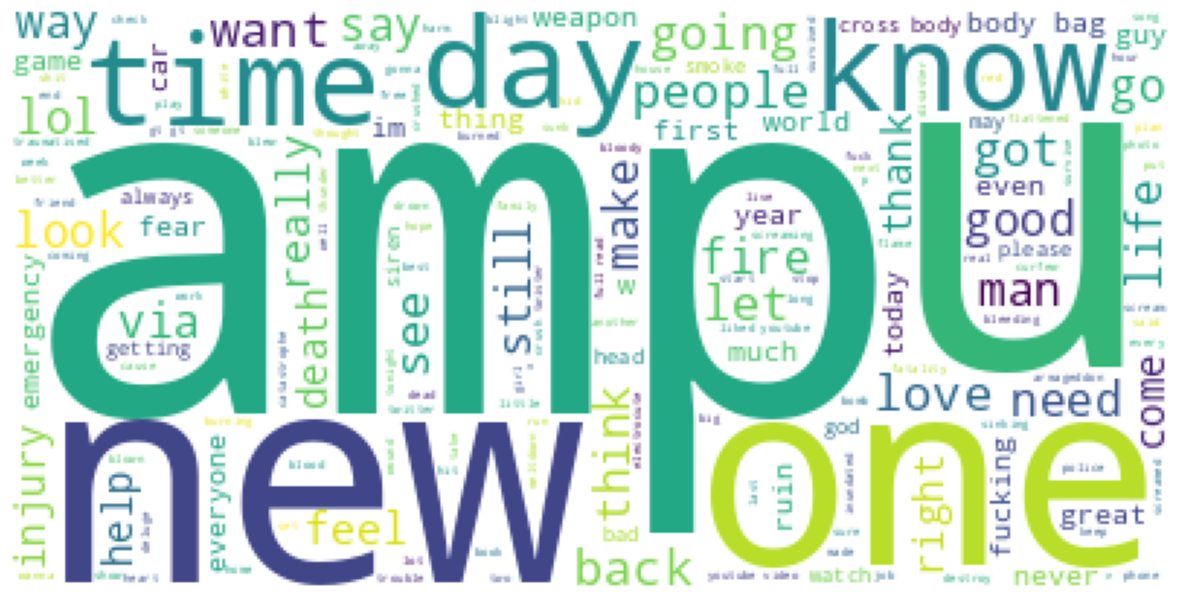

In [82]:
wordcloud = WordCloud(background_color= "white").generate(non_disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Feature Engineering

* Count Vectors
* TF-IDF Vectors (words, characters, n-grams)
* Word Embeddings

TF(t) = (The frequency of occurrence of a term t in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents) / (Number of documents containing the term t)

## Train - Test

In [83]:
y = df.target[:len(df_test)]
X = df.drop(["target","location"],axis=1)[:len(df_test)]

In [84]:
X, y

(      keyword                                               text
 0         221         deed reason earthquake may allah forgive u
 1         221              forest fire near la ronge sask canada
 2         221  resident asked shelter place notified officer ...
 3         221  people receive wildfire evacuation order calif...
 4         221  got sent photo ruby alaska smoke wildfire pour...
 ...       ...                                                ...
 3258       95  store fire alarm went today work evacuate like...
 3259       95  louis sad cancel show everyone leave evacuate ...
 3260       95              evacuate student throw dungeon stupid
 3261       95  u also flew bomb site world war ii warning let...
 3262       95  mygc broken powerlines evacuate gold coast tra...
 
 [3263 rows x 2 columns],
 0       1.0
 1       1.0
 2       1.0
 3       1.0
 4       1.0
        ... 
 3258    1.0
 3259    0.0
 3260    0.0
 3261    1.0
 3262    1.0
 Name: target, Length: 3263, dtype: f

In [85]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.30)
X_train.head()

keyword                                               text
1556       45  deep sleep dream bout fall cliff wake struggli...
435        11       casper rmg bestcomedyvine whats cracking cuz
1829       53                               ina buted girl crush
237         5  fun filled happy hour simmons bar camden hands...
2820       82  heat wave relentless f feel like humidity rele...

## Count Vectors

In [86]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])

CountVectorizer()

In [87]:
x_train_count = vectorizer.fit_transform(X_train['text'])
x_test_count = vectorizer.transform(X_test['text'])

In [92]:
vectorizer.get_feature_names_out()[:5]


array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [89]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## TF- IDF

### Word Level TF-IDF

In [90]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train['text'])
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test['text'])

In [93]:
tf_idf_word_vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

### Ngram Level TF-IDF

In [94]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train['text'])
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test['text'])

In [96]:
tf_idf_ngram_vectorizer.get_feature_names_out()[:5]

array(['aa battery', 'aa battery swear', 'aa mgm', 'aa mgm grand',
       'aaaaaaallll even'], dtype=object)

### Characters level TF-IDF

In [97]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train['text'])
x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test['text'])

In [99]:
tf_idf_chars_vectorizer.get_feature_names_out()[:5]

array([' a', ' a ', ' aa', ' ab', ' ac'], dtype=object)

# Model Building

In [100]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [101]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [102]:
def model_name(model, vector_name):
    model_name= model.__class__.__name__
    if vector_name == "c":
        return model_name+"_count"
    elif vector_name == "n":
        return model_name+"_ngram"
    elif vector_name == "w":
        return model_name+"_word"
    elif vector_name == "ch":
        return model_name+"_chars"
    else:
        return

In [103]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [115]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = pd.concat([all_performances, models], ignore_index=True)
    all_performances= all_performances.drop_duplicates()


In [116]:
def model_performance(x_train_x, x_test_x, model, vector_name):

    x_model = fit_model(model, x_train_x, y_train)

    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)

    print(classification_report(y_test, y_pred, target_names=['non-disaster','disaster']))

## Logistic Regression

In [117]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

non-disaster       0.82      0.89      0.85       609
    disaster       0.79      0.67      0.72       370

    accuracy                           0.81       979
   macro avg       0.80      0.78      0.79       979
weighted avg       0.81      0.81      0.80       979



In [118]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.93      0.86       609
    disaster       0.85      0.62      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [119]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

non-disaster       0.71      0.97      0.82       609
    disaster       0.88      0.34      0.49       370

    accuracy                           0.73       979
   macro avg       0.79      0.66      0.66       979
weighted avg       0.77      0.73      0.70       979



In [120]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.89      0.84       609
    disaster       0.78      0.64      0.70       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979



## Naive Bayes

In [121]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

non-disaster       0.83      0.84      0.84       609
    disaster       0.73      0.72      0.73       370

    accuracy                           0.80       979
   macro avg       0.78      0.78      0.78       979
weighted avg       0.79      0.80      0.80       979



In [122]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

non-disaster       0.81      0.93      0.87       609
    disaster       0.85      0.64      0.73       370

    accuracy                           0.82       979
   macro avg       0.83      0.79      0.80       979
weighted avg       0.82      0.82      0.82       979



In [123]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

non-disaster       0.73      0.96      0.83       609
    disaster       0.88      0.42      0.57       370

    accuracy                           0.76       979
   macro avg       0.81      0.69      0.70       979
weighted avg       0.79      0.76      0.73       979



In [124]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

non-disaster       0.76      0.95      0.84       609
    disaster       0.85      0.51      0.63       370

    accuracy                           0.78       979
   macro avg       0.81      0.73      0.74       979
weighted avg       0.79      0.78      0.76       979



## Random Forests

In [125]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.78      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.76       979
weighted avg       0.79      0.79      0.78       979



In [126]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.90      0.85       609
    disaster       0.80      0.62      0.70       370

    accuracy                           0.80       979
   macro avg       0.80      0.76      0.77       979
weighted avg       0.80      0.80      0.79       979



In [127]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.97      0.81       609
    disaster       0.86      0.31      0.46       370

    accuracy                           0.72       979
   macro avg       0.78      0.64      0.64       979
weighted avg       0.76      0.72      0.68       979



In [128]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

non-disaster       0.77      0.92      0.84       609
    disaster       0.80      0.55      0.65       370

    accuracy                           0.78       979
   macro avg       0.78      0.73      0.74       979
weighted avg       0.78      0.78      0.77       979



## XGBoost

In [129]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

              precision    recall  f1-score   support

non-disaster       0.81      0.91      0.86       609
    disaster       0.82      0.64      0.72       370

    accuracy                           0.81       979
   macro avg       0.81      0.78      0.79       979
weighted avg       0.81      0.81      0.80       979



In [130]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.90      0.85       609
    disaster       0.80      0.62      0.70       370

    accuracy                           0.80       979
   macro avg       0.80      0.76      0.77       979
weighted avg       0.80      0.80      0.79       979



In [131]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

              precision    recall  f1-score   support

non-disaster       0.67      0.96      0.79       609
    disaster       0.79      0.24      0.37       370

    accuracy                           0.69       979
   macro avg       0.73      0.60      0.58       979
weighted avg       0.72      0.69      0.63       979



In [133]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")



              precision    recall  f1-score   support

non-disaster       0.78      0.85      0.82       609
    disaster       0.72      0.61      0.66       370

    accuracy                           0.76       979
   macro avg       0.75      0.73      0.74       979
weighted avg       0.76      0.76      0.76       979



## SVC

In [134]:
svc = svm.SVC()
model_performance(x_train_count, x_test_count, svc, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.94      0.86       609
    disaster       0.86      0.59      0.70       370

    accuracy                           0.81       979
   macro avg       0.83      0.77      0.78       979
weighted avg       0.82      0.81      0.80       979



In [135]:
svc = svm.SVC()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, svc, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.94      0.86       609
    disaster       0.86      0.61      0.71       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979



In [136]:
svc = svm.SVC()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, svc, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.97      0.82       609
    disaster       0.87      0.33      0.48       370

    accuracy                           0.73       979
   macro avg       0.79      0.65      0.65       979
weighted avg       0.77      0.73      0.69       979



In [137]:
svc = svm.SVC()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, svc, "ch")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.79      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.78       979



## SGDClassifier

In [138]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_count, x_test_count, sgdc, "c")

              precision    recall  f1-score   support

non-disaster       0.82      0.85      0.83       609
    disaster       0.73      0.68      0.71       370

    accuracy                           0.79       979
   macro avg       0.77      0.77      0.77       979
weighted avg       0.78      0.79      0.78       979



In [139]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, sgdc, "w")

              precision    recall  f1-score   support

non-disaster       0.82      0.83      0.82       609
    disaster       0.71      0.71      0.71       370

    accuracy                           0.78       979
   macro avg       0.77      0.77      0.77       979
weighted avg       0.78      0.78      0.78       979



In [140]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, sgdc, "n")

              precision    recall  f1-score   support

non-disaster       0.74      0.92      0.82       609
    disaster       0.79      0.48      0.60       370

    accuracy                           0.76       979
   macro avg       0.77      0.70      0.71       979
weighted avg       0.76      0.76      0.74       979



In [141]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, sgdc, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.80      0.80       609
    disaster       0.67      0.68      0.67       370

    accuracy                           0.75       979
   macro avg       0.74      0.74      0.74       979
weighted avg       0.75      0.75      0.75       979



# Performance Evaluation

In [142]:
def display_all_confusion_matrix():
    f, ax = plt.subplots(6, 4, figsize=(20,40), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust()


    f.colorbar(disp.im_)
    plt.show()

IndexError: index 24 is out of bounds for axis 0 with size 24

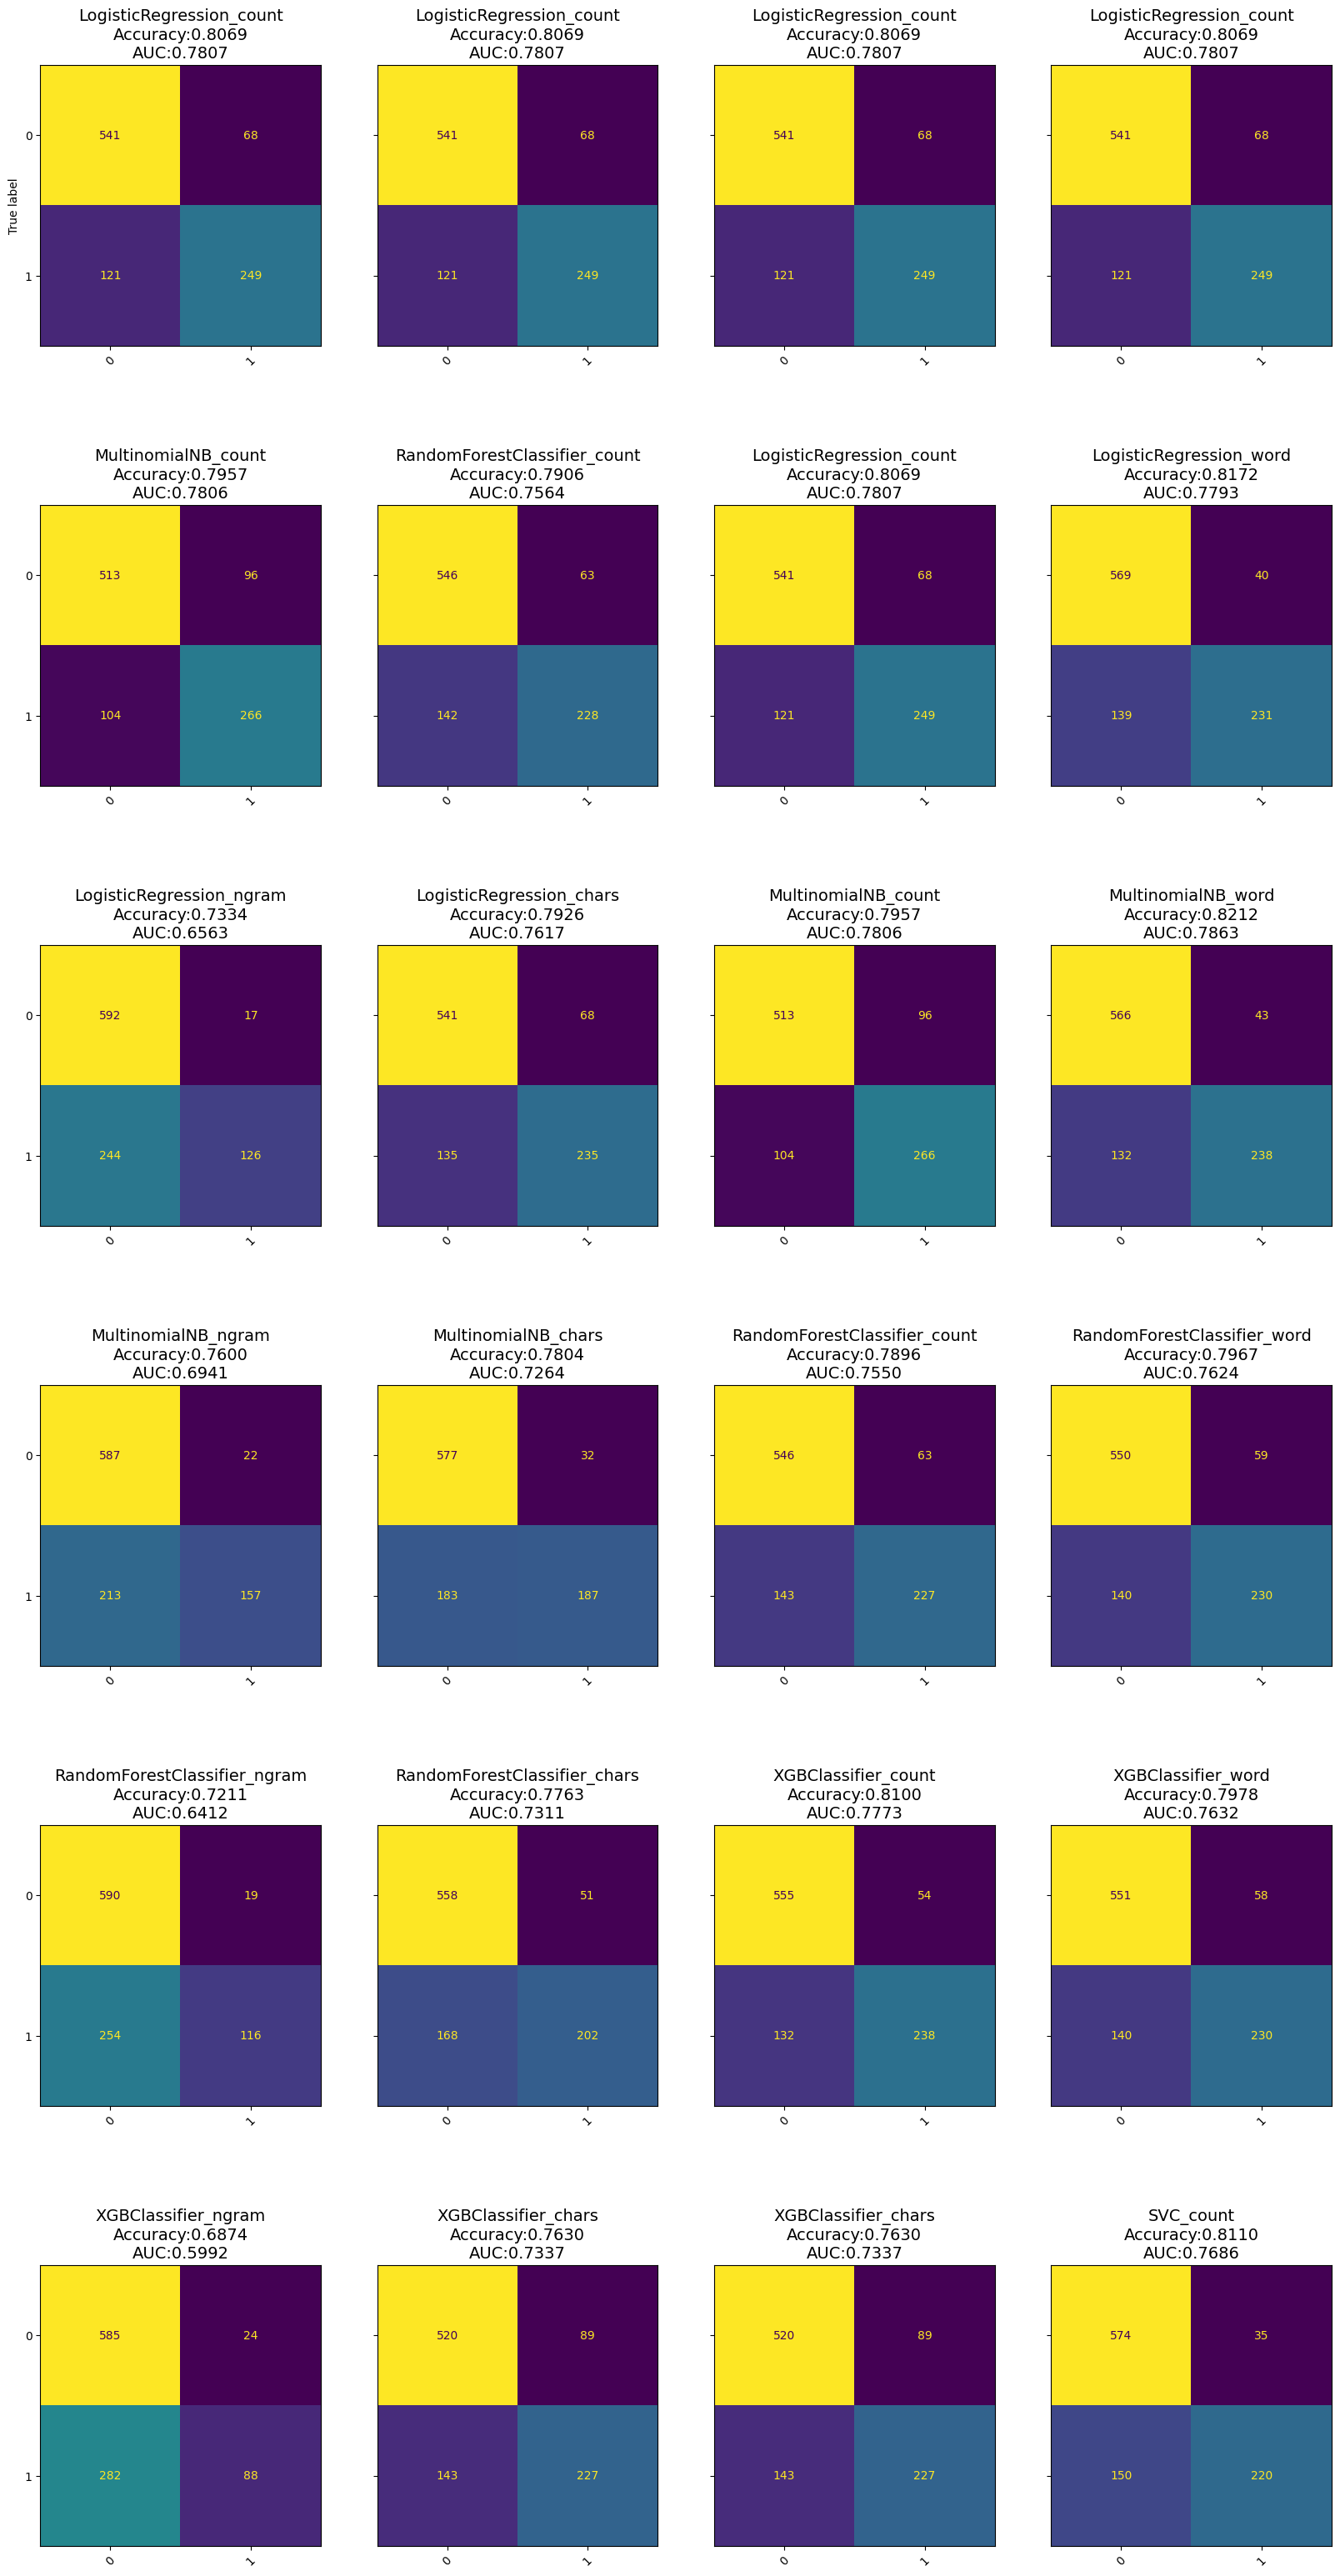

In [144]:
display_all_confusion_matrix()

In [145]:
all_performances.sort_values(by=['f1_score'], ascending=False)

model_name  training_set_score  test_set_score  \
5             MultinomialNB_word            0.920315        0.821246   
4            MultinomialNB_count            0.941331        0.795710   
0       LogisticRegression_count            0.975044        0.806946   
1        LogisticRegression_word            0.893608        0.817160   
12           XGBClassifier_count            0.853327        0.810010   
17                      SVC_word            0.979860        0.815117   
21            SGDClassifier_word            0.988179        0.780388   
20           SGDClassifier_count            0.989930        0.786517   
16                     SVC_count            0.955779        0.811032   
13            XGBClassifier_word            0.894483        0.797753   
3       LogisticRegression_chars            0.863398        0.792646   
9    RandomForestClassifier_word            0.991681        0.796731   
19                     SVC_chars            0.958406        0.790603   
8   RandomForestClassifier_count            0.991681        0.789581   
23           SGDClassifier_chars            0.968476        0.751788   
15           XGBClassifier_chars            0.989054        0.763023   
11  RandomForestClassifier_chars            0.992119        0.776302   
7            MultinomialNB_chars            0.819615        0.780388   
22           SGDClassifier_ngram            0.991243        0.755873   
6            MultinomialNB_ngram            0.985114        0.759959   
2       LogisticRegression_ngram            0.958406        0.733401   
18                     SVC_ngram            0.987741        0.728294   
10  RandomForestClassifier_ngram            0.991243        0.721144   
14           XGBClassifier_ngram            0.708406        0.687436   

    precision    recall  f1_score       AUC  
5    0.846975  0.643243  0.731183  0.786318  
4    0.734807  0.718919  0.726776  0.780642  
0    0.785489  0.672973  0.724891  0.780657  
1    0.852399  0.624324  0.720749  0.779321  
12   0.815068  0.643243  0.719033  0.777287  
17   0.859316  0.610811  0.714060  0.775028  
21   0.711172  0.705405  0.708277  0.765675  
20   0.733333  0.683784  0.707692  0.766358  
16   0.862745  0.594595  0.704000  0.768562  
13   0.798611  0.621622  0.699088  0.763192  
3    0.775578  0.635135  0.698366  0.761738  
9    0.795848  0.621622  0.698027  0.762371  
19   0.785467  0.613514  0.688923  0.755854  
8    0.782759  0.613514  0.687879  0.755033  
23   0.669333  0.678378  0.673826  0.737383  
15   0.718354  0.613514  0.661808  0.733686  
11   0.798419  0.545946  0.648475  0.731101  
7    0.853881  0.505405  0.634975  0.726430  
22   0.793722  0.478378  0.596965  0.701422  
6    0.877095  0.424324  0.571949  0.694100  
2    0.881119  0.340541  0.491228  0.656313  
18   0.871429  0.329730  0.478431  0.650087  
10   0.859259  0.313514  0.459406  0.641157  
14   0.785714  0.237838  0.365145  0.599214

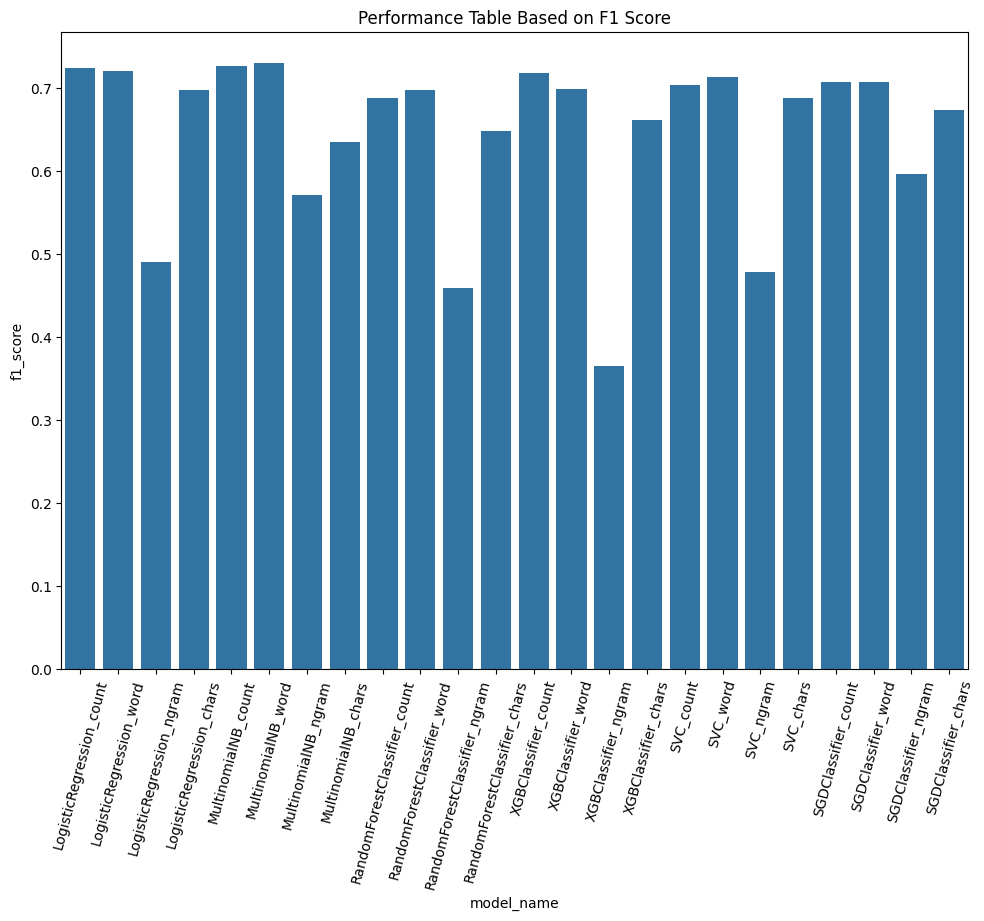

In [148]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('Performance Table Based on F1 Score')

## Hyperparameter Tuning

## Naive Bayes

In [149]:
# Define the hyperparameters to tune
param_grid = {
    'alpha': [11.25,11.5,11.75],  # smoothing parameter
    'fit_prior': [True, False],  # whether to learn class prior probabilities or use uniform priors
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],  # prior probabilities of the classes
}

In [150]:
classifier = naive_bayes.MultinomialNB()

In [151]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

### Count Vector

In [152]:
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [153]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.5, 'class_prior': None, 'fit_prior': True}
Best Score:  0.7859006103881148


In [154]:
best_classifier = grid_search.best_estimator_
accuracy = best_classifier.score(x_test_count, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8161389172625128


### Word Level TF-IDF

In [155]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [156]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.5, 'class_prior': None, 'fit_prior': False}
Best Score:  0.766624438558102


## SVC (Word Level TF-IDF)

In [157]:
param_grid = {
    'C': [0.5, 1.0, 1.5],  # regularization parameter
    'kernel': ['linear', 'rbf'],  # kernel type
    'gamma': ['scale', 'auto']  # kernel coefficient for 'rbf'
}

In [158]:
classifier = SVC()

In [159]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

In [160]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.4s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END ...................C=0.5, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ...................C=0.5, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1.0, 1.5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [161]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score:  0.7775883911090636


## Logistic Regression (Count Vector)

In [162]:
param_grid = {
    'C': [0.25,0.3,0.35],  # inverse regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
    'solver': ['liblinear', 'saga']  # optimization algorithm
}

In [163]:
classifier = linear_model.LogisticRegression()

In [164]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.25, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solv

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.3, 0.35], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [165]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.7863411263388229


# Best Performing Model

In [166]:
best_classifier = grid_search.best_estimator_

In [167]:
best_classifier

LogisticRegression(C=0.25, solver='saga')

In [168]:
model_performance(x_train_count, x_test_count, best_classifier, "c_tuned")

              precision    recall  f1-score   support

non-disaster       0.82      0.92      0.86       609
    disaster       0.83      0.66      0.73       370

    accuracy                           0.82       979
   macro avg       0.82      0.79      0.80       979
weighted avg       0.82      0.82      0.82       979



In [169]:
all_performances.sort_values(by=['f1_score'], ascending=False)

model_name  training_set_score  test_set_score  \
24                          None            0.929510        0.820225   
5             MultinomialNB_word            0.920315        0.821246   
4            MultinomialNB_count            0.941331        0.795710   
0       LogisticRegression_count            0.975044        0.806946   
1        LogisticRegression_word            0.893608        0.817160   
12           XGBClassifier_count            0.853327        0.810010   
17                      SVC_word            0.979860        0.815117   
21            SGDClassifier_word            0.988179        0.780388   
20           SGDClassifier_count            0.989930        0.786517   
16                     SVC_count            0.955779        0.811032   
13            XGBClassifier_word            0.894483        0.797753   
3       LogisticRegression_chars            0.863398        0.792646   
9    RandomForestClassifier_word            0.991681        0.796731   
19                     SVC_chars            0.958406        0.790603   
8   RandomForestClassifier_count            0.991681        0.789581   
23           SGDClassifier_chars            0.968476        0.751788   
15           XGBClassifier_chars            0.989054        0.763023   
11  RandomForestClassifier_chars            0.992119        0.776302   
7            MultinomialNB_chars            0.819615        0.780388   
22           SGDClassifier_ngram            0.991243        0.755873   
6            MultinomialNB_ngram            0.985114        0.759959   
2       LogisticRegression_ngram            0.958406        0.733401   
18                     SVC_ngram            0.987741        0.728294   
10  RandomForestClassifier_ngram            0.991243        0.721144   
14           XGBClassifier_ngram            0.708406        0.687436   

    precision    recall  f1_score       AUC  
24   0.829932  0.659459  0.734940  0.788679  
5    0.846975  0.643243  0.731183  0.786318  
4    0.734807  0.718919  0.726776  0.780642  
0    0.785489  0.672973  0.724891  0.780657  
1    0.852399  0.624324  0.720749  0.779321  
12   0.815068  0.643243  0.719033  0.777287  
17   0.859316  0.610811  0.714060  0.775028  
21   0.711172  0.705405  0.708277  0.765675  
20   0.733333  0.683784  0.707692  0.766358  
16   0.862745  0.594595  0.704000  0.768562  
13   0.798611  0.621622  0.699088  0.763192  
3    0.775578  0.635135  0.698366  0.761738  
9    0.795848  0.621622  0.698027  0.762371  
19   0.785467  0.613514  0.688923  0.755854  
8    0.782759  0.613514  0.687879  0.755033  
23   0.669333  0.678378  0.673826  0.737383  
15   0.718354  0.613514  0.661808  0.733686  
11   0.798419  0.545946  0.648475  0.731101  
7    0.853881  0.505405  0.634975  0.726430  
22   0.793722  0.478378  0.596965  0.701422  
6    0.877095  0.424324  0.571949  0.694100  
2    0.881119  0.340541  0.491228  0.656313  
18   0.871429  0.329730  0.478431  0.650087  
10   0.859259  0.313514  0.459406  0.641157  
14   0.785714  0.237838  0.365145  0.599214

In [170]:
df

keyword  location                                               text  \
0          221  no_{col}         deed reason earthquake may allah forgive u   
1          221  no_{col}              forest fire near la ronge sask canada   
2          221  no_{col}  resident asked shelter place notified officer ...   
3          221  no_{col}  people receive wildfire evacuation order calif...   
4          221  no_{col}  got sent photo ruby alaska smoke wildfire pour...   
...        ...       ...                                                ...   
10743      221  no_{col}   eahquake safety los angeles safety fastener xrwn   
10744      221  no_{col}  storm ri worse last hurricane city amp others ...   
10745      221  no_{col}                      green line derailment chicago   
10746      221  no_{col}            meg issue hazardous weather outlook hwo   
10747      221  no_{col}  cityofcalgary activated municipal emergency pl...   

       target  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
...       ...  
10743     NaN  
10744     NaN  
10745     NaN  
10746     NaN  
10747     NaN  

[10748 rows x 4 columns]

In [171]:
X_pred = df[len(df_train):].drop("target",axis=1)
X_pred["text"]

7485                           happened terrible car crash
7486     heard earthquake different city stay safe ever...
7487     forest fire spot pond goose fleeing across str...
7488                  apocalypse lighting spokane wildfire
7489                    typhoon soudelor kill china taiwan
                               ...                        
10743     eahquake safety los angeles safety fastener xrwn
10744    storm ri worse last hurricane city amp others ...
10745                        green line derailment chicago
10746              meg issue hazardous weather outlook hwo
10747    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [172]:
X_train['text']

1556    deep sleep dream bout fall cliff wake struggli...
435          casper rmg bestcomedyvine whats cracking cuz
1829                                 ina buted girl crush
237     fun filled happy hour simmons bar camden hands...
2820    heat wave relentless f feel like humidity rele...
                              ...                        
1095    st august turkish jet bombed village zergele q...
1130    cryptic guided pilot hiroshima bombing mission...
1294                kanger coil burning fast via r vaping
860                                                 blood
3174    emergency service unsure cope loss paging network
Name: text, Length: 2284, dtype: object

In [173]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['text'])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20129 stored elements and shape (2284, 6945)>

In [174]:
X_pred_count = vectorizer.transform(X_pred["text"])

In [176]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [177]:
X_pred_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [178]:
X_pred_count.shape

(3263, 6945)

In [179]:
x_train_count.shape

(2284, 6945)

In [180]:
y_pred = best_classifier.predict(X_pred_count)

In [181]:
sample_submission["target"].shape

(3263,)

In [182]:
 X_pred["text"].shape

(3263,)

In [183]:
y_pred.shape

(3263,)

In [184]:
data = {'tweet': X_pred["text"], 'location': X_pred['location'] , 'predicted_label': y_pred}
predicted_data = pd.DataFrame(data).reset_index(drop=True)

In [185]:
predicted_data['actual_label'] = sample_submission["target"].reset_index(drop=True)

In [186]:
predicted_data

tweet  location  \
0                           happened terrible car crash  no_{col}   
1     heard earthquake different city stay safe ever...  no_{col}   
2     forest fire spot pond goose fleeing across str...  no_{col}   
3                  apocalypse lighting spokane wildfire  no_{col}   
4                    typhoon soudelor kill china taiwan  no_{col}   
...                                                 ...       ...   
3258   eahquake safety los angeles safety fastener xrwn  no_{col}   
3259  storm ri worse last hurricane city amp others ...  no_{col}   
3260                      green line derailment chicago  no_{col}   
3261            meg issue hazardous weather outlook hwo  no_{col}   
3262  cityofcalgary activated municipal emergency pl...  no_{col}   

      predicted_label  actual_label  
0                 0.0             0  
1                 1.0             0  
2                 1.0             0  
3                 1.0             0  
4                 0.0             0  
...               ...           ...  
3258              0.0             0  
3259              1.0             0  
3260              1.0             0  
3261              0.0             0  
3262              0.0             0  

[3263 rows x 4 columns]

In [187]:
sample_submission["target"].unique()

array([0])

In [188]:
right_predictions = predicted_data[(predicted_data["predicted_label"] == predicted_data["actual_label"])]
right_predictions = right_predictions.reset_index(drop=True)
right_predictions

tweet  location  \
0                           happened terrible car crash  no_{col}   
1                    typhoon soudelor kill china taiwan  no_{col}   
2      probably still show life arsenal yesterday eh eh  no_{col}   
3                                                   hey  no_{col}   
4                                              nice hat  no_{col}   
...                                                 ...       ...   
2399  see yr old pkk suicide bomber detonated bomb t...  no_{col}   
2400  conference attendee blue line airport derailed...  no_{col}   
2401   eahquake safety los angeles safety fastener xrwn  no_{col}   
2402            meg issue hazardous weather outlook hwo  no_{col}   
2403  cityofcalgary activated municipal emergency pl...  no_{col}   

      predicted_label  actual_label  
0                 0.0             0  
1                 0.0             0  
2                 0.0             0  
3                 0.0             0  
4                 0.0             0  
...               ...           ...  
2399              0.0             0  
2400              0.0             0  
2401              0.0             0  
2402              0.0             0  
2403              0.0             0  

[2404 rows x 4 columns]

In [189]:
accuracy = len(right_predictions)*100/len(predicted_data)
accuracy

73.67453263867607